In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

import requests
from bs4 import BeautifulSoup 
import json
import re
import time

In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
color_dict = {'CACECB': 'серебристый', 
              'FAFBFB':'белый', 
              'EE1D19':'красный', 
              '97948F':'серый',
              '660099':'пурпурный',
              '040001':'чёрный',
              '4A2197':'фиолетовый',
              '200204':'коричневый',
              '0000CC':'синий',
              '007F00':'зелёный',
              'C49648':'бежевый',
              '22A0F8':'голубой',
              'DEA522':'золотистый',
              'FFD600': 'жёлтый',
              'FF8649':'оранжевый',
              'FFC0CB':'розовый',
              'серебристый': 'серебристый', 
              'белый':'белый', 
              'красный':'красный', 
              'серый':'серый',
              'пурпурный':'пурпурный',
              'чёрный':'чёрный',
              'фиолетовый':'фиолетовый',
              'коричневый':'коричневый',
              'синий':'синий',
              'зелёный':'зелёный',
              'бежевый':'бежевый',
              'голубой':'голубой',
              'золотистый':'золотистый',
              'жёлтый': 'жёлтый',
              'оранжевый':'оранжевый',
              'розовый':'розовый'
             }


def MAPE(y_fact, y_pred):
    return np.mean(np.abs((y_pred-y_fact)/y_fact))


def processing_dataset_for_catboost(df_test, columns): 
    '''
    Первичная обработка датасета.
    После обработки необходимо проверить наличие пропусков,
    а также избавиться от выбросов и оставить марки только тех автомобилей, которые есть в тестовом датасете
    '''
    # bodyType
    df_test['bodyType'] = df_test['bodyType'].apply(lambda x: 'внедорожник' if x in ['внедорожник 3 дв.', 'внедорожник 5 дв.', 'внедорожник открытый'] else x)
    df_test['bodyType'] = df_test['bodyType'].apply(lambda x: 'пикап' if x in ['пикап двойная кабина', 'пикап одинарная кабина', 'пикап полуторная кабина'] else x)
    df_test['bodyType'] = df_test['bodyType'].apply(lambda x: 'седан' if x in ['седан 2 дв.', 'седан-хардтоп', 'универсал 5 дв.'] else x)
    df_test['bodyType'] = df_test['bodyType'].apply(lambda x: 'хэтчбек' if x in ['хэтчбек 3 дв.', 'хэтчбек 5 дв.', 'купе', 'купе-хардтоп', 'лифтбек', 'фастбек'] else x)
    df_test['bodyType'] = df_test['bodyType'].apply(lambda x: 'минивэн' if x in ['компактвэн', 'микровэн', 'пикап', 'фургон'] else x)
    df_test['bodyType'] = df_test['bodyType'].apply(lambda x: 'кабриолет' if x in ['родстер', 'тарга', 'лимузин'] else x)
    # Лимузин отнес к кабриолетам по причине их цены
    
    
    # brand не трогаем
    
    
    # color не трогаем
    
    
    # engineDisplacement
    df_test['engineDisplacement'] = df_test['engineDisplacement'].apply(lambda x: 0.0 if x.strip()=='LTR' else float(x.strip()[0:3]))
    
    
    # enginePower
    df_test['enginePower'] = df_test['enginePower'].apply(lambda x: int(x.replace(' N12', '')))
    
    
    # fuelType относим газ к бензину, тк мощности таких двигателей одинаковы
    df_test['fuelType'] = df_test['fuelType'].apply(lambda x: 'бензин' if x.strip()=='газ' else x) 
    
    
    # mileage 
    if df_test.mileage.dtype!=('int64' or 'float'):
        df_test['mileage'] = df_test['mileage'].apply(lambda x: x.replace('км', ''))
        df_test['mileage'] = df_test['mileage'].apply(lambda x: int(x.replace('\xa0', '')))
    
    
    # modelDate не трогаем
    
    
    
    # numberOfDoors
    df_test['numberOfDoors'] = df_test['numberOfDoors'].apply(lambda x: 2 if x==0 else x)
    
    
    # productionDate не трогаем
           
        
        
    # vehicleTransmission не трогаем
    
    
    
    # Владельцы не трогаем
    
    
    
    # ПТС
    df_test['ПТС'].fillna(df_test['ПТС'].mode()[0], inplace=True)
    
    
    
    # Привод не трогаем
    
    
    
    # Руль не трогаем
    
    
    # price
    if 'price' in columns:
        if df_test.price.dtype!=('int64' or 'float'):
            df_test['price'] = df_test['price'].apply(lambda x: x.replace('\xa0', ''))
            df_test['price'] = df_test['price'].apply(lambda x: int(x.replace('₽', '')))
            
        Q1, Q3 = df_test.price.describe()['25%'], df_test.price.describe()['75%']
        IQR = Q3 - Q1
        df_test = df_test[df_test['price'] <= (Q3 + 1.5*IQR)]
        
    return df_test


def get_volume(series):
    """Функция возвращает объем двигателя при обработке определенного столбца"""
    pattern = re.compile("\d+\.\d+")
    substr = pattern.search(str(series))
    if substr != None:
        volume = float(substr[0])
        if volume > 10:
            return 0
        else:
            return volume
    else:
        return 0
        

# Известно из предыдущей итерации исследования задачи:

### Тестовые данные парсились в октябре 2020 года

### Убираем столбцы:
- car_url (можно улучшить в дальнейшем)
- complectation_dict (можно улучшить в дальнейшем)
- description (можно улучшить в дальнейшем)
- equipment_dict (можно улучшить в дальнейшем)
- image
- model_info
- model_name (много уникальных значений)
- name 
- parsing_unixtime
- priceCurrency
- super_gen (можно улучшить в дальнейшем)
- vehicleConfiguration
- vendor 
- Владение (огромное число пропусков)
- Состояние (мало отличающихся значений)
- Таможня (только уникальные значения)

### Оставляем столбцы:
- bodyType 
- brand 
- color 
- engineDisplacement 
- enginePower 
- fuelType 
- mileage
- modelDate
- numberOfDoors 
- productionDate 
- vehicleTransmission 
- Владельцы 
- ПТС 
- Привод 
- Руль
- price (в зависимости от датасета)

# Обработка тестового датасета для CatBoost

In [4]:
df_test = pd.read_csv('test.csv')

columns = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 
           'mileage', 'modelDate', 'numberOfDoors', 'productionDate', 
           'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль']

brandsInTest = ['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI']

df_test = df_test[columns]
df_test = processing_dataset_for_catboost(df_test, columns)

df_test = df_test[df_test['brand'].isin(brandsInTest)]
display(df_test.head())
display(df_test.info())
display(df_test.nunique())
display(df_test.isnull().sum())

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль
0,хэтчбек,SKODA,синий,1.2,105,бензин,74000,2013,5,2014,роботизированная,3 или более,Оригинал,передний,Левый
1,хэтчбек,SKODA,чёрный,1.6,110,бензин,60563,2017,5,2017,механическая,1 владелец,Оригинал,передний,Левый
2,хэтчбек,SKODA,серый,1.8,152,бензин,88000,2013,5,2014,роботизированная,1 владелец,Оригинал,передний,Левый
3,хэтчбек,SKODA,коричневый,1.6,110,бензин,95000,2013,5,2014,автоматическая,1 владелец,Оригинал,передний,Левый
4,хэтчбек,SKODA,белый,1.8,152,бензин,58536,2008,5,2012,автоматическая,1 владелец,Оригинал,передний,Левый


<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 0 to 34685
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             34686 non-null  object 
 1   brand                34686 non-null  object 
 2   color                34686 non-null  object 
 3   engineDisplacement   34686 non-null  float64
 4   enginePower          34686 non-null  int64  
 5   fuelType             34686 non-null  object 
 6   mileage              34686 non-null  int64  
 7   modelDate            34686 non-null  int64  
 8   numberOfDoors        34686 non-null  int64  
 9   productionDate       34686 non-null  int64  
 10  vehicleTransmission  34686 non-null  object 
 11  Владельцы            34686 non-null  object 
 12  ПТС                  34686 non-null  object 
 13  Привод               34686 non-null  object 
 14  Руль                 34686 non-null  object 
dtypes: float64(1), int64(5), object(9)
m

None

bodyType                   5
brand                     12
color                     16
engineDisplacement        55
enginePower              315
fuelType                   4
mileage                11268
modelDate                 66
numberOfDoors              4
productionDate            69
vehicleTransmission        4
Владельцы                  3
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

bodyType               0
brand                  0
color                  0
engineDisplacement     0
enginePower            0
fuelType               0
mileage                0
modelDate              0
numberOfDoors          0
productionDate         0
vehicleTransmission    0
Владельцы              0
ПТС                    0
Привод                 0
Руль                   0
dtype: int64

# Обработка собственного тренировочного датасета для CatBoost
# Из-за малого количества данных предсказательная сила модели хуже, чем в готовом датасете

In [5]:
df_parsed = pd.concat([pd.read_csv('cars_data_1.csv'),
                      pd.read_csv('cars_data_2.csv'),
                      pd.read_csv('cars_data_3.csv'),
                      pd.read_csv('cars_data_4.csv'),
                      pd.read_csv('cars_data_5.csv'),
                      pd.read_csv('cars_data_6.csv'),
                      pd.read_csv('cars_data_7.csv'),
               pd.read_csv('cars_data_8.csv')]).reset_index(drop=True)

columns = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 
           'mileage', 'modelDate', 'numberOfDoors', 'productionDate', 
           'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'price']
brandsInTest = ['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI']

df_parsed = df_parsed[df_parsed['brand'].isin(brandsInTest)]
df_parsed = df_parsed[columns].drop_duplicates().reset_index(drop=True)

df_parsed = processing_dataset_for_catboost(df_parsed, columns)

display(df_parsed.head())
display(df_parsed.info())
display(df_parsed.nunique())
display(df_parsed.isnull().sum())

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,price
0,минивэн,TOYOTA,чёрный,2.8,177,дизель,173595,2015,2,2017,автоматическая,3 или более,Оригинал,полный,Левый,2417000
1,внедорожник,TOYOTA,коричневый,2.7,185,бензин,228601,2012,5,2013,автоматическая,1 владелец,Оригинал,полный,Левый,1579000
2,минивэн,MERCEDES,чёрный,2.1,136,дизель,139354,2010,4,2013,автоматическая,3 или более,Оригинал,полный,Левый,1695000
3,внедорожник,TOYOTA,коричневый,2.8,177,дизель,137497,2015,5,2017,автоматическая,1 владелец,Оригинал,полный,Левый,2519000
4,внедорожник,MERCEDES,серый,2.0,211,бензин,101832,2015,5,2015,автоматическая,2 владельца,Оригинал,полный,Левый,2127000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7631 entries, 0 to 8116
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             7631 non-null   object 
 1   brand                7631 non-null   object 
 2   color                7631 non-null   object 
 3   engineDisplacement   7631 non-null   float64
 4   enginePower          7631 non-null   int64  
 5   fuelType             7631 non-null   object 
 6   mileage              7631 non-null   int64  
 7   modelDate            7631 non-null   int64  
 8   numberOfDoors        7631 non-null   int64  
 9   productionDate       7631 non-null   int64  
 10  vehicleTransmission  7631 non-null   object 
 11  Владельцы            7631 non-null   object 
 12  ПТС                  7631 non-null   object 
 13  Привод               7631 non-null   object 
 14  Руль                 7631 non-null   object 
 15  price                7631 non-null   i

None

bodyType                  5
brand                    12
color                    16
engineDisplacement       48
enginePower             222
fuelType                  4
mileage                4860
modelDate                45
numberOfDoors             4
productionDate           43
vehicleTransmission       4
Владельцы                 3
ПТС                       2
Привод                    3
Руль                      2
price                  2479
dtype: int64

bodyType               0
brand                  0
color                  0
engineDisplacement     0
enginePower            0
fuelType               0
mileage                0
modelDate              0
numberOfDoors          0
productionDate         0
vehicleTransmission    0
Владельцы              0
ПТС                    0
Привод                 0
Руль                   0
price                  0
dtype: int64

# Обработка готового тренировочного датасета для CatBoost

In [6]:
df = pd.read_csv('all_auto_ru_09_09_2020.csv')

columns = ['bodyType', 'brand', 'color', 'engineDisplacement', 'enginePower', 'fuelType', 
           'mileage', 'modelDate', 'numberOfDoors', 'productionDate', 
           'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль', 'price', 'name']
brandsInTest = ['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI']

df = df[df['brand'].isin(brandsInTest)]
df = df[columns].drop_duplicates().reset_index(drop=True)

# Обработка датасета
df = df[df['bodyType'].notnull()]
df['bodyType'] = df['bodyType'].apply(lambda x: x.split()[0])
df['bodyType'] = df['bodyType'].apply(lambda x: 'внедорожник' if x.lower() in ['внедорожник 3 дв.', 'внедорожник 5 дв.', 'внедорожник открытый'] else x.lower())
df['bodyType'] = df['bodyType'].apply(lambda x: 'пикап' if x.lower() in ['пикап двойная кабина', 'пикап одинарная кабина', 'пикап полуторная кабина'] else x.lower())
df['bodyType'] = df['bodyType'].apply(lambda x: 'седан' if x.lower() in ['седан 2 дв.', 'седан-хардтоп', 'универсал'] else x.lower())
df['bodyType'] = df['bodyType'].apply(lambda x: 'хэтчбек' if x.lower() in ['хэтчбек 3 дв.', 'хэтчбек 5 дв.', 'купе', 'купе-хардтоп', 'лифтбек', 'фастбек'] else x.lower())
df['bodyType'] = df['bodyType'].apply(lambda x: 'минивэн' if x.lower() in ['компактвэн', 'микровэн', 'пикап', 'фургон'] else x.lower())
df['bodyType'] = df['bodyType'].apply(lambda x: 'кабриолет' if x.lower() in ['родстер', 'тарга', 'лимузин'] else x.lower())

df = df[df.brand.isin(brandsInTest)]

df.color = df.color.map(color_dict)

df['engineDisplacement'] = df['name'].apply(get_volume)
df.drop(['name'], axis=1, inplace=True)

df['enginePower'] = df['enginePower']

df['fuelType'] = df['fuelType'].apply(lambda x: 'бензин' if (x=='газ' or x=='универсал') else x)

df['mileage'] = df['mileage']

df['modelDate'] = df['modelDate']

df['numberOfDoors'] = df['numberOfDoors']

df['productionDate'] = df['productionDate']

temp_dict = {'MECHANICAL' : 'механическая', 'AUTOMATIC' : 'автоматическая', 'ROBOT' : 'роботизированная', 'VARIATOR' : 'вариатор', np.nan: 'автоматическая'}
df['vehicleTransmission'] = df['vehicleTransmission'].map(temp_dict)

temp_dict = {1.0 : '1\xa0владелец', 2.0 : '2\xa0владельца', 3.0 : '3 или более'}
df['Владельцы'] = df['Владельцы'].map(temp_dict)
df = df[df['Владельцы'].notnull()]

temp_dict = {'ORIGINAL' : 'Оригинал', 'DUPLICATE' : 'Дубликат'}
df['ПТС'] = df['ПТС'].map(temp_dict)

df['Привод'] = df['Привод']

temp_dict = {'LEFT' : 'Левый', 'RIGHT' : 'Правый'}
df['Руль'] = df['Руль'].map(temp_dict)

df = df[df['price'].notnull()]

display(df.head())
display(df.info())
display(df.nunique())
display(df.isnull().sum())

,bodyType,brand,color,engineDisplacement,enginePower,fuelType,mileage,modelDate,numberOfDoors,productionDate,vehicleTransmission,Владельцы,ПТС,Привод,Руль,price
0,седан,AUDI,чёрный,2.8,174.0,бензин,350000,1990.0,4.0,1991,механическая,3 или более,Оригинал,полный,Левый,200000.0
1,седан,AUDI,красный,1.8,90.0,бензин,173424,1982.0,4.0,1986,механическая,3 или более,Оригинал,передний,Левый,60000.0
2,седан,AUDI,синий,2.3,136.0,бензин,230000,1988.0,5.0,1989,механическая,3 или более,Оригинал,полный,Левый,99000.0
3,седан,AUDI,серебристый,1.8,90.0,бензин,240000,1988.0,4.0,1989,механическая,3 или более,Оригинал,передний,Левый,65000.0
4,седан,AUDI,чёрный,2.0,101.0,бензин,300000,1990.0,4.0,1991,механическая,3 или более,Дубликат,передний,Левый,100000.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 37832 entries, 0 to 43921
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             37832 non-null  object 
 1   brand                37832 non-null  object 
 2   color                37832 non-null  object 
 3   engineDisplacement   37832 non-null  float64
 4   enginePower          37832 non-null  float64
 5   fuelType             37832 non-null  object 
 6   mileage              37832 non-null  int64  
 7   modelDate            37832 non-null  float64
 8   numberOfDoors        37832 non-null  float64
 9   productionDate       37832 non-null  int64  
 10  vehicleTransmission  37832 non-null  object 
 11  Владельцы            37832 non-null  object 
 12  ПТС                  37832 non-null  object 
 13  Привод               37832 non-null  object 
 14  Руль                 37832 non-null  object 
 15  price                37832 non-null 

None

bodyType                  5
brand                    12
color                    16
engineDisplacement       55
enginePower             311
fuelType                  4
mileage                9746
modelDate                69
numberOfDoors             5
productionDate           72
vehicleTransmission       4
Владельцы                 3
ПТС                       2
Привод                    3
Руль                      2
price                  2940
dtype: int64

bodyType               0
brand                  0
color                  0
engineDisplacement     0
enginePower            0
fuelType               0
mileage                0
modelDate              0
numberOfDoors          0
productionDate         0
vehicleTransmission    0
Владельцы              0
ПТС                    0
Привод                 0
Руль                   0
price                  0
dtype: int64

# Моделирование. CatBoost

Команды ниже взяты из видео (таймкод 3:40):
https://www.youtube.com/watch?v=wQt4kgAOgV0&t=366s

pip install --upgrade catboost

pip install --upgrade ipywidgets

https://catboost.ai/docs/installation/python-installation-additional-data-visualization-packages.html#python-installation-additional-data-visualization-packages

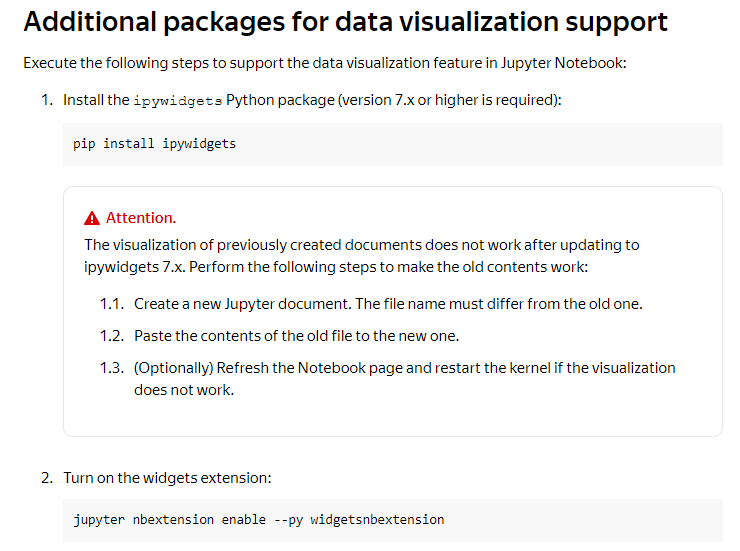

In [14]:
from catboost import CatBoostRegressor

In [12]:
model = CatBoostRegressor(iterations=20000,
                          learning_rate=0.005,
                          random_seed=322,
                          # вывод лога каждые 20 итераций
                          metric_period=20,
                          # отслеживание кастомной метрики
                          custom_metric=['MAPE'],
                          # если возникло переобучение, то использовать лучшую модель
                          use_best_model=True,
                          # детектор переобучения
                          od_type='Iter',
                          od_wait=20,
                          # детектор переобучения именно по указанной метрике
                          eval_metric='MAPE',
                          # тип бутстрапа
                          #bootstrap_type='Bernoulli',
                          # параметр, отвечающий за рандом. Можно пробовать крутить от нуля и больше
                          random_strength=0,
                          # максимальная глубина дерева
                          max_depth=12
                        )
print('Model is fitted : ', model.is_fitted())
print('Model params : ', model.get_params())

Model is fitted :  False
Model params :  {'iterations': 20000, 'learning_rate': 0.005, 'loss_function': 'RMSE', 'od_wait': 20, 'od_type': 'Iter', 'random_seed': 322, 'use_best_model': True, 'metric_period': 20, 'random_strength': 0, 'custom_metric': ['MAPE'], 'eval_metric': 'MAPE', 'max_depth': 12}


In [9]:
cat_features = df_test.dtypes[df_test.dtypes=='object'].index
cat_features

Index(['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission',
       'Владельцы', 'ПТС', 'Привод', 'Руль'],
      dtype='object')

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['price'], axis=1),
                                                   df['price'],
                                                   shuffle=True,
                                                   test_size=0.30,
                                                   random_state=322)

model.fit(X_train,
          y_train,
          cat_features=cat_features,
          eval_set=(X_test, y_test),
          plot=True,
          logging_level='Silent'
        )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Лучшее значение метрики MAPE:
- train(learn) : 0.1296 (0.1824 без max_depth=12)
- test : 0.1684 (0.1884 без max_depth=12)

### Обучим модель на всем готовом датасете

In [14]:
catRegressor = CatBoostRegressor(iterations=15000,
                          learning_rate=0.005,
                          random_seed=322,
                          # вывод лога каждые 20 итераций
                          metric_period=20,
                          # отслеживание кастомной метрики
                          custom_metric=['MAPE'],
                          # если возникло переобучение, то использовать лучшую модель
                          #use_best_model=True,
                          # детектор переобучения
                          od_type='Iter',
                          od_wait=20,
                          # детектор переобучения именно по указанной метрике
                          eval_metric='MAPE',
                          # тип бутстрапа
                          #bootstrap_type='Bernoulli',
                          # параметр, отвечающий за рандом. Можно пробовать крутить от нуля и больше
                          random_strength=0,
                          # максимальная глубина дерева
                          max_depth=12
                        )
print('Model is fitted : ', catRegressor.is_fitted())
print('Model params : ', catRegressor.get_params())

Model is fitted :  False
Model params :  {'iterations': 15000, 'learning_rate': 0.005, 'loss_function': 'RMSE', 'od_wait': 20, 'od_type': 'Iter', 'random_seed': 322, 'metric_period': 20, 'random_strength': 0, 'custom_metric': ['MAPE'], 'eval_metric': 'MAPE', 'max_depth': 12}


In [15]:
catRegressor.fit(df.drop(['price'], axis=1),
          df['price'],
          cat_features=cat_features,
          plot=True,
          logging_level='Silent'
        )

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

catRegressor.save_model('catBoost_15k_12depth_5e-3lr')

In [16]:
result = catRegressor.predict(df_test)
submission = pd.read_csv('sample_submission.csv')
submission['price'] = result
submission.to_csv('submission.csv', index=False)

# Обработка датасетов df_test и df(готового) для использования в моделях, не поддерживающих фичи типа object  

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 0 to 34685
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             34686 non-null  object 
 1   brand                34686 non-null  object 
 2   color                34686 non-null  object 
 3   engineDisplacement   34686 non-null  float64
 4   enginePower          34686 non-null  int64  
 5   fuelType             34686 non-null  object 
 6   mileage              34686 non-null  int64  
 7   modelDate            34686 non-null  int64  
 8   numberOfDoors        34686 non-null  int64  
 9   productionDate       34686 non-null  int64  
 10  vehicleTransmission  34686 non-null  object 
 11  Владельцы            34686 non-null  object 
 12  ПТС                  34686 non-null  object 
 13  Привод               34686 non-null  object 
 14  Руль                 34686 non-null  object 
dtypes: float64(1), int64(5), object(9)
m

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37832 entries, 0 to 43921
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             37832 non-null  object 
 1   brand                37832 non-null  object 
 2   color                37832 non-null  object 
 3   engineDisplacement   37832 non-null  float64
 4   enginePower          37832 non-null  float64
 5   fuelType             37832 non-null  object 
 6   mileage              37832 non-null  int64  
 7   modelDate            37832 non-null  float64
 8   numberOfDoors        37832 non-null  float64
 9   productionDate       37832 non-null  int64  
 10  vehicleTransmission  37832 non-null  object 
 11  Владельцы            37832 non-null  object 
 12  ПТС                  37832 non-null  object 
 13  Привод               37832 non-null  object 
 14  Руль                 37832 non-null  object 
 15  price                37832 non-null 

In [9]:
def additional_processing(df):
    length = len(df)
    bodyTypeSeries = df.groupby(['bodyType']).agg({'bodyType' : 'count'}).bodyType
    brandSeries = df.groupby(['brand']).agg({'brand' : 'count'}).brand
    
    df['bodyType'] = df['bodyType'].apply(lambda x: bodyTypeSeries[x] / length)
    df['brand'] = df['brand'].apply(lambda x: brandSeries[x] / length)
    df['color'] = df['color'].apply(lambda x: 1 if x in ['серебристый', 'белый', 'серый', 'чёрный', 'коричневый', 'синий', 'бежевый'] else 0)
    df = pd.get_dummies(df, columns=['fuelType'], prefix=['fuelType'])
    df['vehicleTransmission'] = df['vehicleTransmission'].apply(lambda x: 0 if x=='механическая' else 0)
    temp_dict = {'1\xa0владелец': 1, '2\xa0владельца': 2, '3 или более': 3}
    df['Владельцы'] = df['Владельцы'].map(temp_dict)
    df['ПТС'] = df['ПТС'].apply(lambda x: 1 if x=='Оригинал' else 0)
    df = pd.get_dummies(df, columns=['Привод'], prefix=['Привод'])
    df['Руль'] = df['Руль'].apply(lambda x: 1 if x=='Левый' else 0)
    
    return df

### Обработаем фичи следующим образом (см. функцию additional_processing):
- bodyType: доля в датасете (или get_dummies)
- brand: доля в датасете (или get_dummies)
- color: серебристый, белый, серый, чёрный, коричневый, синий, бежевый обозначим за 1(популярные), остальные цвета 0
- fuelType: get_dummies
- vehicleTransmission: 0 -- механическая, остальные -- 1
- Владельцы: переводим в число от 1 до 3
- ПТС: 1 -- оригинал, 0 -- дубликат
- Привод: get_dummies
- Руль: 1 -- левый, 0 -- правый              

In [10]:
df = additional_processing(df)
df_test = additional_processing(df_test)
display(df_test.info())
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 0 to 34685
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             34686 non-null  float64
 1   brand                34686 non-null  float64
 2   color                34686 non-null  int64  
 3   engineDisplacement   34686 non-null  float64
 4   enginePower          34686 non-null  int64  
 5   mileage              34686 non-null  int64  
 6   modelDate            34686 non-null  int64  
 7   numberOfDoors        34686 non-null  int64  
 8   productionDate       34686 non-null  int64  
 9   vehicleTransmission  34686 non-null  int64  
 10  Владельцы            34686 non-null  int64  
 11  ПТС                  34686 non-null  int64  
 12  Руль                 34686 non-null  int64  
 13  fuelType_бензин      34686 non-null  uint8  
 14  fuelType_гибрид      34686 non-null  uint8  
 15  fuelType_дизель      34686 non-null 

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37832 entries, 0 to 43921
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             37832 non-null  float64
 1   brand                37832 non-null  float64
 2   color                37832 non-null  int64  
 3   engineDisplacement   37832 non-null  float64
 4   enginePower          37832 non-null  float64
 5   mileage              37832 non-null  int64  
 6   modelDate            37832 non-null  float64
 7   numberOfDoors        37832 non-null  float64
 8   productionDate       37832 non-null  int64  
 9   vehicleTransmission  37832 non-null  int64  
 10  Владельцы            37832 non-null  int64  
 11  ПТС                  37832 non-null  int64  
 12  Руль                 37832 non-null  int64  
 13  price                37832 non-null  float64
 14  fuelType_бензин      37832 non-null  uint8  
 15  fuelType_гибрид      37832 non-null 

None

# Моделирование. XGBoost

In [15]:
import xgboost as xgb

In [12]:
xgbRegressor = xgb.XGBRegressor(# вывод информации
                                verbosity=1,
                                # оптимизируемая метрика
                                objective='reg:squarederror',
                                # тип бустинга
                                booster='gbtree',
                                # доля фичей, участвующих в построении дерева
                                colsample_bytree=0.60,
                                # шаг обучения
                                learning_rate=0.0025,
                                # максимальная глубина дерева
                                max_depth=16,
                                # L1 регуляризатор, по умолчанию 0
                                alpha=1,
                                #
                                n_estimators=15000,
                                random_state=322
                                )
print(xgbRegressor)

XGBRegressor(alpha=1, base_score=None, booster='gbtree', colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.6, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=0.0025, max_delta_step=None, max_depth=16,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=15000, n_jobs=None, num_parallel_tree=None,
             random_state=322, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=1)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['price'], axis=1),
                                                   df['price'],
                                                   shuffle=True,
                                                   test_size=0.30,
                                                   random_state=322)

xgbRegressor.fit(X_train, y_train)

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.0025, max_delta_step=0, max_depth=16,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=15000, n_jobs=12, num_parallel_tree=1,
             random_state=322, reg_alpha=1, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=1)

In [14]:
y_pred = xgbRegressor.predict(X_test)
print(MAPE(y_test, y_pred))

0.16627865913706016


### Обучим модель на всем датасете

In [ ]:
xgbRegressor.fit(df.drop(['price'], axis=1), df['price'])
y_pred = xgbRegressor.predict(df_test)

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['price'] = y_pred
submission.to_csv('submission.csv', index=False)

# Моделирование. Random Forest Regressor

In [46]:
from sklearn.ensemble import RandomForestRegressor
RFRegressor = RandomForestRegressor(n_estimators=5000,
                                   max_depth=30,
                                   max_features='sqrt',
                                   #min_samples_leaf=3,
                                   #min_samples_split=5,
                                   n_jobs=-1,
                                   random_state=322,
                                   )

In [42]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['price'], axis=1),
                                                   df['price'],
                                                   shuffle=True,
                                                   test_size=0.30,
                                                   random_state=322)

In [43]:
RFRegressor.fit(X_train, y_train)
y_pred = RFRegressor.predict(X_test)
print(MAPE(y_test, y_pred))

0.16804828760974982


### Обучим модель на всей выборке

In [47]:
RFRegressor.fit(df.drop(['price'], axis=1), df['price'])
y_pred = RFRegressor.predict(df_test)
submission = pd.read_csv('sample_submission.csv')
submission['price'] = y_pred
submission.to_csv('submission.csv', index=False)

# Моделирование. Stacking

In [22]:
from sklearn.ensemble import StackingRegressor

In [23]:
estimators = [('catBoost', CatBoostRegressor(iterations=10000,
                          learning_rate=0.005,
                          random_seed=322,
                          # вывод лога каждые 20 итераций
                          metric_period=20,
                          # отслеживание кастомной метрики
                          # custom_metric=['MAPE'],
                          # если возникло переобучение, то использовать лучшую модель
                          #use_best_model=True,
                          # детектор переобучения
                          od_type='Iter',
                          od_wait=20,
                          # детектор переобучения именно по указанной метрике
                          eval_metric='MAPE',
                          # тип бутстрапа
                          #bootstrap_type='Bernoulli',
                          # параметр, отвечающий за рандом. Можно пробовать крутить от нуля и больше
                          random_strength=0,
                          # максимальная глубина дерева
                          max_depth=10
                        )),
              ('xgBoost', xgb.XGBRegressor(# вывод информации
                                verbosity=1,
                                # оптимизируемая метрика
                                objective='reg:squarederror',
                                # тип бустинга
                                booster='gbtree',
                                # доля фичей, участвующих в построении дерева
                                colsample_bytree=0.60,
                                # шаг обучения
                                learning_rate=0.0025,
                                # максимальная глубина дерева
                                max_depth=10,
                                # L1 регуляризатор, по умолчанию 0
                                alpha=1,
                                #
                                n_estimators=10000,
                                random_state=322
                                ))]
              
stacking_regressor = StackingRegressor(estimators=estimators, cv=3)
X_train, X_test, y_train, y_test = train_test_split(df.drop(['price'], axis=1),
                                                   df['price'],
                                                   shuffle=True,
                                                   test_size=0.30,
                                                   random_state=322)
stacking_regressor.fit(X_train, y_train)              


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 1.6331465	total: 33.4ms	remaining: 5m 33s
20:	learn: 1.5096555	total: 706ms	remaining: 5m 35s
40:	learn: 1.4035342	total: 1.39s	remaining: 5m 38s
60:	learn: 1.3072047	total: 2.09s	remaining: 5m 40s
80:	learn: 1.2191168	total: 2.76s	remaining: 5m 37s
100:	learn: 1.1369241	total: 3.43s	remaining: 5m 36s
120:	learn: 1.0597138	total: 4.12s	remaining: 5m 36s
140:	learn: 0.9904240	total: 4.8s	remaining: 5m 35s
160:	learn: 0.9270259	total: 5.46s	remaining: 5m 33s
180:	learn: 0.8691029	total: 6.14s	remaining: 5m 33s
200:	learn: 0.8156388	total: 6.81s	remaining: 5m 32s
220:	learn: 0.7687764	total: 7.48s	remaining: 5m 31s
240:	learn: 0.7264879	total: 8.15s	remaining: 5m 30s
260:	learn: 0.6855082	total: 8.81s	remaining: 5m 28s
280:	learn: 0.6496885	total: 9.48s	remaining: 5m 27s
300:	learn: 0.6170356	total: 10.1s	remaining: 5m 26s
320:	learn: 0.5875736	total: 10.8s	remaining: 5m 25s
340:	learn: 0.5599814	total: 11.5s	remaining: 5m 24s
360:	learn: 0.5342865	total: 12.1s	remaining: 5m 23s

3060:	learn: 0.2002305	total: 1m 40s	remaining: 3m 47s
3080:	learn: 0.1997727	total: 1m 41s	remaining: 3m 46s
3100:	learn: 0.1991875	total: 1m 41s	remaining: 3m 46s
3120:	learn: 0.1986815	total: 1m 42s	remaining: 3m 45s
3140:	learn: 0.1982464	total: 1m 43s	remaining: 3m 44s
3160:	learn: 0.1979434	total: 1m 43s	remaining: 3m 44s
3180:	learn: 0.1975656	total: 1m 44s	remaining: 3m 43s
3200:	learn: 0.1969772	total: 1m 44s	remaining: 3m 42s
3220:	learn: 0.1965201	total: 1m 45s	remaining: 3m 42s
3240:	learn: 0.1961355	total: 1m 46s	remaining: 3m 41s
3260:	learn: 0.1957676	total: 1m 46s	remaining: 3m 40s
3280:	learn: 0.1950483	total: 1m 47s	remaining: 3m 40s
3300:	learn: 0.1946127	total: 1m 48s	remaining: 3m 39s
3320:	learn: 0.1940778	total: 1m 48s	remaining: 3m 39s
3340:	learn: 0.1936943	total: 1m 49s	remaining: 3m 38s
3360:	learn: 0.1931934	total: 1m 50s	remaining: 3m 37s
3380:	learn: 0.1928318	total: 1m 50s	remaining: 3m 37s
3400:	learn: 0.1923933	total: 1m 51s	remaining: 3m 36s
3420:	lear

6080:	learn: 0.1651838	total: 3m 20s	remaining: 2m 9s
6100:	learn: 0.1650225	total: 3m 21s	remaining: 2m 8s
6120:	learn: 0.1648070	total: 3m 22s	remaining: 2m 8s
6140:	learn: 0.1647169	total: 3m 22s	remaining: 2m 7s
6160:	learn: 0.1646071	total: 3m 23s	remaining: 2m 6s
6180:	learn: 0.1644599	total: 3m 24s	remaining: 2m 6s
6200:	learn: 0.1642963	total: 3m 25s	remaining: 2m 5s
6220:	learn: 0.1641362	total: 3m 25s	remaining: 2m 5s
6240:	learn: 0.1639877	total: 3m 26s	remaining: 2m 4s
6260:	learn: 0.1638371	total: 3m 27s	remaining: 2m 3s
6280:	learn: 0.1637065	total: 3m 28s	remaining: 2m 3s
6300:	learn: 0.1635766	total: 3m 28s	remaining: 2m 2s
6320:	learn: 0.1634013	total: 3m 29s	remaining: 2m 1s
6340:	learn: 0.1632780	total: 3m 30s	remaining: 2m 1s
6360:	learn: 0.1631579	total: 3m 31s	remaining: 2m
6380:	learn: 0.1630267	total: 3m 31s	remaining: 2m
6400:	learn: 0.1629152	total: 3m 32s	remaining: 1m 59s
6420:	learn: 0.1628099	total: 3m 33s	remaining: 1m 58s
6440:	learn: 0.1627179	total: 3m

9120:	learn: 0.1497783	total: 5m 7s	remaining: 29.7s
9140:	learn: 0.1497206	total: 5m 8s	remaining: 29s
9160:	learn: 0.1496469	total: 5m 9s	remaining: 28.3s
9180:	learn: 0.1495764	total: 5m 9s	remaining: 27.6s
9200:	learn: 0.1495076	total: 5m 10s	remaining: 27s
9220:	learn: 0.1494141	total: 5m 11s	remaining: 26.3s
9240:	learn: 0.1493682	total: 5m 12s	remaining: 25.6s
9260:	learn: 0.1493131	total: 5m 12s	remaining: 25s
9280:	learn: 0.1492527	total: 5m 13s	remaining: 24.3s
9300:	learn: 0.1491903	total: 5m 14s	remaining: 23.6s
9320:	learn: 0.1491230	total: 5m 14s	remaining: 22.9s
9340:	learn: 0.1490703	total: 5m 15s	remaining: 22.3s
9360:	learn: 0.1489681	total: 5m 16s	remaining: 21.6s
9380:	learn: 0.1489072	total: 5m 17s	remaining: 20.9s
9400:	learn: 0.1488165	total: 5m 17s	remaining: 20.2s
9420:	learn: 0.1487536	total: 5m 18s	remaining: 19.6s
9440:	learn: 0.1486766	total: 5m 19s	remaining: 18.9s
9460:	learn: 0.1486111	total: 5m 19s	remaining: 18.2s
9480:	learn: 0.1485458	total: 5m 20s	r

2180:	learn: 0.2032088	total: 1m 22s	remaining: 4m 56s
2200:	learn: 0.2024164	total: 1m 23s	remaining: 4m 55s
2220:	learn: 0.2019119	total: 1m 24s	remaining: 4m 55s
2240:	learn: 0.2014080	total: 1m 25s	remaining: 4m 54s
2260:	learn: 0.2006010	total: 1m 25s	remaining: 4m 53s
2280:	learn: 0.2000220	total: 1m 26s	remaining: 4m 52s
2300:	learn: 0.1995749	total: 1m 27s	remaining: 4m 52s
2320:	learn: 0.1989136	total: 1m 28s	remaining: 4m 51s
2340:	learn: 0.1982829	total: 1m 28s	remaining: 4m 50s
2360:	learn: 0.1976849	total: 1m 29s	remaining: 4m 49s
2380:	learn: 0.1972449	total: 1m 30s	remaining: 4m 49s
2400:	learn: 0.1967436	total: 1m 31s	remaining: 4m 48s
2420:	learn: 0.1960782	total: 1m 31s	remaining: 4m 47s
2440:	learn: 0.1955340	total: 1m 32s	remaining: 4m 46s
2460:	learn: 0.1949032	total: 1m 33s	remaining: 4m 46s
2480:	learn: 0.1945184	total: 1m 34s	remaining: 4m 45s
2500:	learn: 0.1938707	total: 1m 34s	remaining: 4m 44s
2520:	learn: 0.1931891	total: 1m 35s	remaining: 4m 43s
2540:	lear

5200:	learn: 0.1617439	total: 3m 18s	remaining: 3m 3s
5220:	learn: 0.1615885	total: 3m 19s	remaining: 3m 2s
5240:	learn: 0.1614732	total: 3m 20s	remaining: 3m 2s
5260:	learn: 0.1613685	total: 3m 21s	remaining: 3m 1s
5280:	learn: 0.1612673	total: 3m 22s	remaining: 3m
5300:	learn: 0.1611806	total: 3m 22s	remaining: 2m 59s
5320:	learn: 0.1610534	total: 3m 23s	remaining: 2m 59s
5340:	learn: 0.1609132	total: 3m 24s	remaining: 2m 58s
5360:	learn: 0.1608103	total: 3m 25s	remaining: 2m 57s
5380:	learn: 0.1607386	total: 3m 26s	remaining: 2m 57s
5400:	learn: 0.1606060	total: 3m 27s	remaining: 2m 56s
5420:	learn: 0.1604705	total: 3m 27s	remaining: 2m 55s
5440:	learn: 0.1603296	total: 3m 28s	remaining: 2m 54s
5460:	learn: 0.1601923	total: 3m 29s	remaining: 2m 54s
5480:	learn: 0.1600385	total: 3m 30s	remaining: 2m 53s
5500:	learn: 0.1598881	total: 3m 31s	remaining: 2m 52s
5520:	learn: 0.1597223	total: 3m 31s	remaining: 2m 51s
5540:	learn: 0.1595340	total: 3m 32s	remaining: 2m 51s
5560:	learn: 0.159

8200:	learn: 0.1458691	total: 5m 21s	remaining: 1m 10s
8220:	learn: 0.1458151	total: 5m 21s	remaining: 1m 9s
8240:	learn: 0.1457180	total: 5m 22s	remaining: 1m 8s
8260:	learn: 0.1456593	total: 5m 23s	remaining: 1m 8s
8280:	learn: 0.1455863	total: 5m 24s	remaining: 1m 7s
8300:	learn: 0.1455266	total: 5m 25s	remaining: 1m 6s
8320:	learn: 0.1454347	total: 5m 26s	remaining: 1m 5s
8340:	learn: 0.1453685	total: 5m 26s	remaining: 1m 5s
8360:	learn: 0.1452787	total: 5m 27s	remaining: 1m 4s
8380:	learn: 0.1452001	total: 5m 28s	remaining: 1m 3s
8400:	learn: 0.1451103	total: 5m 29s	remaining: 1m 2s
8420:	learn: 0.1450344	total: 5m 30s	remaining: 1m 1s
8440:	learn: 0.1449463	total: 5m 30s	remaining: 1m 1s
8460:	learn: 0.1448777	total: 5m 31s	remaining: 1m
8480:	learn: 0.1448095	total: 5m 32s	remaining: 59.6s
8500:	learn: 0.1447056	total: 5m 33s	remaining: 58.8s
8520:	learn: 0.1446086	total: 5m 34s	remaining: 58s
8540:	learn: 0.1445289	total: 5m 35s	remaining: 57.2s
8560:	learn: 0.1444404	total: 5m

1260:	learn: 0.2806768	total: 45.2s	remaining: 5m 13s
1280:	learn: 0.2795006	total: 46s	remaining: 5m 13s
1300:	learn: 0.2777861	total: 46.8s	remaining: 5m 13s
1320:	learn: 0.2754226	total: 47.7s	remaining: 5m 13s
1340:	learn: 0.2729126	total: 48.5s	remaining: 5m 12s
1360:	learn: 0.2713772	total: 49.1s	remaining: 5m 11s
1380:	learn: 0.2697669	total: 49.8s	remaining: 5m 10s
1400:	learn: 0.2680713	total: 50.4s	remaining: 5m 9s
1420:	learn: 0.2668720	total: 50.9s	remaining: 5m 7s
1440:	learn: 0.2657627	total: 51.4s	remaining: 5m 5s
1460:	learn: 0.2649979	total: 51.9s	remaining: 5m 3s
1480:	learn: 0.2638169	total: 52.5s	remaining: 5m 2s
1500:	learn: 0.2629858	total: 53s	remaining: 5m
1520:	learn: 0.2619517	total: 53.6s	remaining: 4m 58s
1540:	learn: 0.2609531	total: 54.2s	remaining: 4m 57s
1560:	learn: 0.2596727	total: 54.8s	remaining: 4m 56s
1580:	learn: 0.2589722	total: 55.5s	remaining: 4m 55s
1600:	learn: 0.2578652	total: 56.2s	remaining: 4m 54s
1620:	learn: 0.2569017	total: 56.8s	remai

4280:	learn: 0.1843155	total: 2m 38s	remaining: 3m 31s
4300:	learn: 0.1839623	total: 2m 39s	remaining: 3m 31s
4320:	learn: 0.1836831	total: 2m 40s	remaining: 3m 30s
4340:	learn: 0.1834384	total: 2m 40s	remaining: 3m 29s
4360:	learn: 0.1832122	total: 2m 41s	remaining: 3m 29s
4380:	learn: 0.1829250	total: 2m 42s	remaining: 3m 28s
4400:	learn: 0.1825757	total: 2m 43s	remaining: 3m 27s
4420:	learn: 0.1823088	total: 2m 44s	remaining: 3m 27s
4440:	learn: 0.1821033	total: 2m 44s	remaining: 3m 26s
4460:	learn: 0.1818615	total: 2m 45s	remaining: 3m 25s
4480:	learn: 0.1816150	total: 2m 46s	remaining: 3m 25s
4500:	learn: 0.1814695	total: 2m 47s	remaining: 3m 24s
4520:	learn: 0.1812737	total: 2m 48s	remaining: 3m 23s
4540:	learn: 0.1811942	total: 2m 49s	remaining: 3m 23s
4560:	learn: 0.1808339	total: 2m 49s	remaining: 3m 22s
4580:	learn: 0.1806285	total: 2m 50s	remaining: 3m 21s
4600:	learn: 0.1804214	total: 2m 51s	remaining: 3m 21s
4620:	learn: 0.1801318	total: 2m 52s	remaining: 3m 20s
4640:	lear

7300:	learn: 0.1567603	total: 4m 42s	remaining: 1m 44s
7320:	learn: 0.1566444	total: 4m 43s	remaining: 1m 43s
7340:	learn: 0.1564971	total: 4m 44s	remaining: 1m 43s
7360:	learn: 0.1563621	total: 4m 45s	remaining: 1m 42s
7380:	learn: 0.1562252	total: 4m 46s	remaining: 1m 41s
7400:	learn: 0.1561447	total: 4m 46s	remaining: 1m 40s
7420:	learn: 0.1559964	total: 4m 47s	remaining: 1m 40s
7440:	learn: 0.1558598	total: 4m 48s	remaining: 1m 39s
7460:	learn: 0.1557198	total: 4m 49s	remaining: 1m 38s
7480:	learn: 0.1555071	total: 4m 50s	remaining: 1m 37s
7500:	learn: 0.1553638	total: 4m 51s	remaining: 1m 36s
7520:	learn: 0.1552521	total: 4m 51s	remaining: 1m 36s
7540:	learn: 0.1551550	total: 4m 52s	remaining: 1m 35s
7560:	learn: 0.1550582	total: 4m 53s	remaining: 1m 34s
7580:	learn: 0.1549039	total: 4m 54s	remaining: 1m 33s
7600:	learn: 0.1547679	total: 4m 55s	remaining: 1m 33s
7620:	learn: 0.1546321	total: 4m 56s	remaining: 1m 32s
7640:	learn: 0.1545057	total: 4m 56s	remaining: 1m 31s
7660:	lear

340:	learn: 0.5757796	total: 13s	remaining: 6m 8s
360:	learn: 0.5495378	total: 13.8s	remaining: 6m 7s
380:	learn: 0.5258798	total: 14.6s	remaining: 6m 7s
400:	learn: 0.5054918	total: 15.3s	remaining: 6m 7s
420:	learn: 0.4874575	total: 16.1s	remaining: 6m 6s
440:	learn: 0.4732081	total: 16.9s	remaining: 6m 6s
460:	learn: 0.4596534	total: 17.7s	remaining: 6m 5s
480:	learn: 0.4468651	total: 18.5s	remaining: 6m 5s
500:	learn: 0.4356743	total: 19.2s	remaining: 6m 4s
520:	learn: 0.4248067	total: 20s	remaining: 6m 3s
540:	learn: 0.4148780	total: 20.8s	remaining: 6m 2s
560:	learn: 0.4037528	total: 21.5s	remaining: 6m 2s
580:	learn: 0.3934067	total: 22.3s	remaining: 6m 1s
600:	learn: 0.3864363	total: 23.1s	remaining: 6m
620:	learn: 0.3807681	total: 23.8s	remaining: 5m 59s
640:	learn: 0.3767357	total: 24.5s	remaining: 5m 58s
660:	learn: 0.3741937	total: 25.3s	remaining: 5m 57s
680:	learn: 0.3714004	total: 26.1s	remaining: 5m 56s
700:	learn: 0.3654710	total: 26.9s	remaining: 5m 56s
720:	learn: 0.

3400:	learn: 0.1844256	total: 2m 10s	remaining: 4m 12s
3420:	learn: 0.1841800	total: 2m 10s	remaining: 4m 11s
3440:	learn: 0.1839775	total: 2m 11s	remaining: 4m 11s
3460:	learn: 0.1835934	total: 2m 12s	remaining: 4m 10s
3480:	learn: 0.1834057	total: 2m 13s	remaining: 4m 9s
3500:	learn: 0.1831957	total: 2m 14s	remaining: 4m 9s
3520:	learn: 0.1828900	total: 2m 14s	remaining: 4m 8s
3540:	learn: 0.1825872	total: 2m 15s	remaining: 4m 7s
3560:	learn: 0.1822074	total: 2m 16s	remaining: 4m 6s
3580:	learn: 0.1819079	total: 2m 17s	remaining: 4m 6s
3600:	learn: 0.1816615	total: 2m 18s	remaining: 4m 5s
3620:	learn: 0.1814177	total: 2m 18s	remaining: 4m 4s
3640:	learn: 0.1812145	total: 2m 19s	remaining: 4m 3s
3660:	learn: 0.1809742	total: 2m 20s	remaining: 4m 3s
3680:	learn: 0.1806275	total: 2m 21s	remaining: 4m 2s
3700:	learn: 0.1803228	total: 2m 21s	remaining: 4m 1s
3720:	learn: 0.1799649	total: 2m 22s	remaining: 4m
3740:	learn: 0.1796840	total: 2m 23s	remaining: 4m
3760:	learn: 0.1794143	total: 

6420:	learn: 0.1545334	total: 4m 5s	remaining: 2m 16s
6440:	learn: 0.1543796	total: 4m 6s	remaining: 2m 16s
6460:	learn: 0.1542621	total: 4m 7s	remaining: 2m 15s
6480:	learn: 0.1541176	total: 4m 7s	remaining: 2m 14s
6500:	learn: 0.1539731	total: 4m 8s	remaining: 2m 13s
6520:	learn: 0.1538581	total: 4m 9s	remaining: 2m 13s
6540:	learn: 0.1537013	total: 4m 10s	remaining: 2m 12s
6560:	learn: 0.1535943	total: 4m 10s	remaining: 2m 11s
6580:	learn: 0.1534232	total: 4m 11s	remaining: 2m 10s
6600:	learn: 0.1533067	total: 4m 12s	remaining: 2m 10s
6620:	learn: 0.1531638	total: 4m 13s	remaining: 2m 9s
6640:	learn: 0.1530591	total: 4m 14s	remaining: 2m 8s
6660:	learn: 0.1529185	total: 4m 14s	remaining: 2m 7s
6680:	learn: 0.1527650	total: 4m 15s	remaining: 2m 7s
6700:	learn: 0.1526481	total: 4m 16s	remaining: 2m 6s
6720:	learn: 0.1525170	total: 4m 17s	remaining: 2m 5s
6740:	learn: 0.1523675	total: 4m 18s	remaining: 2m 4s
6760:	learn: 0.1522471	total: 4m 18s	remaining: 2m 4s
6780:	learn: 0.1521319	t

9460:	learn: 0.1402113	total: 6m 17s	remaining: 21.5s
9480:	learn: 0.1401304	total: 6m 18s	remaining: 20.7s
9500:	learn: 0.1400914	total: 6m 19s	remaining: 19.9s
9520:	learn: 0.1399971	total: 6m 20s	remaining: 19.1s
9540:	learn: 0.1399259	total: 6m 21s	remaining: 18.4s
9560:	learn: 0.1398385	total: 6m 22s	remaining: 17.6s
9580:	learn: 0.1397845	total: 6m 23s	remaining: 16.8s
9600:	learn: 0.1397038	total: 6m 24s	remaining: 16s
9620:	learn: 0.1396116	total: 6m 25s	remaining: 15.2s
9640:	learn: 0.1395585	total: 6m 26s	remaining: 14.4s
9660:	learn: 0.1394561	total: 6m 27s	remaining: 13.6s
9680:	learn: 0.1393543	total: 6m 28s	remaining: 12.8s
9700:	learn: 0.1392633	total: 6m 29s	remaining: 12s
9720:	learn: 0.1391917	total: 6m 30s	remaining: 11.2s
9740:	learn: 0.1390903	total: 6m 31s	remaining: 10.4s
9760:	learn: 0.1390057	total: 6m 32s	remaining: 9.6s
9780:	learn: 0.1389198	total: 6m 32s	remaining: 8.8s
9800:	learn: 0.1388345	total: 6m 33s	remaining: 8s
9820:	learn: 0.1387750	total: 6m 34s	

StackingRegressor(cv=3,
                  estimators=[('catBoost',
                               <catboost.core.CatBoostRegressor object at 0x000002B3250C40A0>),
                              ('xgBoost',
                               XGBRegressor(alpha=1, base_score=None,
                                            booster='gbtree',
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=0.0025,
                                            max_delta_step=None, max_depth=10,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,

In [24]:
y_pred = stacking_regressor.predict(X_test)
print(MAPE(y_test, y_pred))

1.334417072190549


#### Качество очень плохое, я что-то сделал не так, но я не понимаю, что именно. Модель на всей выборке обучать не будем. Само обучение длится очень долго

# Итоги

## Топ использованных алгоритмов:
- RandomForestRegressor. Наилучший результат при: n_estimators=5000, max_depth=30, min_samples_leaf=5. Обучение заняло примерно 5 минут. Метрика на Kaggle: 13.64
- CatBoostRegressor. Наилучший результат при: n_estimators = 15k, learning_rate = 5e-3, max_depth=12. Обучение заняло примерно 1 час. Метрика на Kaggle: 14.13
- XGBoost. Наилучший результат при: n_estimators = 20k, learning_rate = 2.5e-3, max_depth=12. Обучение заняло примерно 10-20 минут. Метрика на Kaggle: 16.15

## Дальнейшие пути улучшения результата:
1. **Дополнительный парсинг данных по URLs из test.csv**
2. **Работа со словарем complectation_dict и equipment_dict; определение доп. опций в автомобиле**
3. **Обработка поля description. Так можно узнать тип продавца: частник или физ. лицо**
4. **Обработка поля super_gen. Можно вытащить оттуда пару новых признаков для датасета, например, acceleration и fuel_rate**
5. **mileage: удалить выбросы. Это врядли повлияет на результат**
8. **Учесть разницу в курсе валют на текущий момент и на дату парсинга, т.е. октябрь 2020 года** (при использовании готового датасета неактуально)
9. **Не убирать из рассмотрения марки автомобилей, которых нет в тестовом датасете**
10. **Логарифмирование таргета и других столбцов, стандартизация** (для деревьев не должно влиять на результат)